In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sklearn.model_selection
import sklearn
import cv2
import pandas as pd
from skimage.io import imread 
from skimage.transform import resize 
from skimage.color import rgb2gray
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# SYDE 522 Final Project

## By Anirudh Kilambi and Youngwoo Lee

The purpose of this project is to apply techniques used in class to detect and identify faults and defects found in sewer pipelines. To accomplish this, we used training data found from the 2022 VideoPipe challenge for Real-World Video Understanding for Urban Pipe Inspection. For this project, we investigated the effectiveness of Convolutional Neural Networks (CNN) and Support Vector Machines (SVM) in order to come to an experimental conclusion on which model is most effective for this task.

## Data Loading

In [ ]:
# the path to all the raw videos broken up frame by frame
# folder structure should be:
    # raw_images
    #  | video_name
    #       | frame_number.jpg
raw_data_path = "data/raw_images/"

# these are the videos we want to consider, first index is the folder inside raw_images, second index is the categorization (0 = no defect, 1 = defect)
# all defect videos have wall obstructions
categorization = [("4736", 0), ("2383", 0), ("3520", 0), ("d20017", 1), ("26852", 1)]

# this is to split up relative paths to each individual frame. We are considering all frames for an individual video to have the same categorization, 
# we will have a pseudo "dataset" of (paths to frames, category)
sewer_data = {}
sewer_data["data"] = []
sewer_data["target"] = []
for folder, cat in categorization:
    images = os.listdir(f"{raw_data_path}{folder}/")
    for image in images:
        sewer_data["data"].append(f"{raw_data_path}{folder}/{image}")
        sewer_data["target"].append(cat)

    
# split the data into training, testing and validation
x = sewer_data["data"]
y = sewer_data["target"]
x_trainvalid, x_test, y_trainvalid, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)
# print(len(y), len(y_train,), len(y_test), len(y_valid))
# print(x[1].split("/")[2])

['26852', '2383', 'd20017', '4736']
1066 852 214 214
4736


In [ ]:
# once the "training" data is split, we need to store it into folders. This is so we can use keras' image dataset from directory to
# read in all the data, and have it correctly categorized/labelled.
# This requires the following folder structure.
    # data (= to "type" below)
    #   | category (0, or 1)
    #       | image name
# all image names need to be prefixed with the video name, as originally each video's frames have the same naming convention in raw_data, frame_{frame_number}.jpg
# final image name in this data folder is: {video_name}_frame_{frame_number}.jpg
def moveFiles(x,y,type):
    xpath = f"data/{type}/0/"
    ypath = f"data/{type}/1/"
    if not os.path.exists(xpath):
        os.makedirs(xpath)
    if not os.path.exists(ypath):
        os.makedirs(ypath)
    
    for i in range(len(x)):
        x_split = x[i].split("/")
        img_name = x_split[2] + x_split[3]

        if y[i] == 0:
            os.system(f"cp {x[i]} {xpath}/{img_name}")
        else:
            os.system(f"cp {x[i]} {ypath}/{img_name}")

moveFiles(x_train, y_train, "train")
moveFiles(x_test, y_test, "test")
moveFiles(x_valid, y_valid, "valid")

In [ ]:
# originally, all images are 1280x720 in RGB. This needs to be resized to a smaller resolution due to compute limitations.
# Since the original images are in 16:9, 640x360 was chosen for the resized image. These images all get rewritten with this resize.
base_path = f"data"
types = ["valid", "train", "test"]
for type in types:
    type_base_path = f"{base_path}/{type}/"
    categories = os.listdir(type_base_path)
    for category in categories:
        category_base_path = f"{type_base_path}{category}/"
        images = os.listdir(category_base_path)
        for image in images:
            image_path = f"{category_base_path}{image}"
            img = cv2.imread(image_path)
            resized_image = cv2.resize(img, (640, 360))
            cv2.imwrite(image_path, resized_image)


data/valid/0/473613.jpg
[[[148 151 159]
  [153 156 164]
  [112 115 123]
  ...
  [ 44  63  78]
  [ 61  80  95]
  [ 55  74  89]]

 [[138 141 149]
  [124 127 135]
  [163 166 174]
  ...
  [ 73  92 107]
  [ 61  80  95]
  [ 45  64  79]]

 [[142 145 153]
  [141 144 152]
  [199 202 210]
  ...
  [113 132 147]
  [124 143 158]
  [121 140 155]]

 ...

 [[118 144 160]
  [101 127 143]
  [111 137 153]
  ...
  [102 108 107]
  [101 107 106]
  [101 107 106]]

 [[117 143 159]
  [106 132 148]
  [112 138 154]
  ...
  [103 109 108]
  [101 107 106]
  [100 106 105]]

 [[115 140 156]
  [104 130 146]
  [103 129 145]
  ...
  [101 107 106]
  [100 106 105]
  [ 98 104 103]]]
data/valid/0/4736223.jpg
[[[251 230 222]
  [252 231 223]
  [252 231 223]
  ...
  [ 63  70  73]
  [ 62  69  72]
  [ 62  69  72]]

 [[252 231 223]
  [252 231 223]
  [252 231 223]
  ...
  [ 63  70  73]
  [ 62  69  72]
  [ 62  69  72]]

 [[252 231 223]
  [252 231 223]
  [252 231 223]
  ...
  [ 63  70  73]
  [ 62  69  72]
  [ 60  69  72]]

 ...

 [[

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1000,
    image_size=(640, 360))

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1000,
    image_size=(640, 360))

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/valid/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1000,
    image_size=(640, 360))

print(valid_ds)

Found 852 files belonging to 2 classes.
Found 214 files belonging to 2 classes.
Found 214 files belonging to 2 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 640, 360, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


## Part 1: Convolutional Neural Networks 

In [4]:
model = tf.keras.models.Sequential([
  # tf.keras.layers.InputLayer(input_shape = (640, 360, 3)),
  # tf.keras.layers.Flatten(input_shape=(640, 360, 3)),   
  # tf.keras.layers.Dense(32, activation='relu'),    
  # tf.keras.layers.Dense(2, activation='softmax'),
    
    # Input layer
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(360, 640, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
    
  #   # Second convolutional block
  # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D((2, 2)),
    
  #   # Third convolutional block
  # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Flatten and Dense layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(2, activation='softmax')
])

def my_loss(y_true, y_predict):
    return (y_true-y_predict)**2

model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics=['accuracy'] 
             )

model.fit(train_ds, epochs=5, validation_data=valid_ds)
loss, accuracy = model.evaluate(test_ds)

print(accuracy)


/Users/ylee/Documents/Projects/RoboNav/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


: 

: 

## Testing Accuracy over Epochs

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7887 - loss: 0.2054 - val_accuracy: 0.6308 - val_loss: 0.3692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6308 - loss: 0.3692
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6279 - loss: 0.3721 - val_accuracy: 0.6168 - val_loss: 0.3832
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6279 - loss: 0.3721 - val_accuracy: 0.6168 - val_loss: 0.3832
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6168 - loss: 0.3832
Epoch 1/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3721 - loss: 0.6279 - val_accuracy: 0.3832 - val_loss: 0.6168
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3721 - loss: 0.6279 - val_accuracy: 0.3832 - val_loss: 0.6168
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3721 - loss: 0.6279 - val_accuracy: 0.3832 - val_loss: 0.6168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.3832 - loss: 0.6168
Epoch 1/4
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0

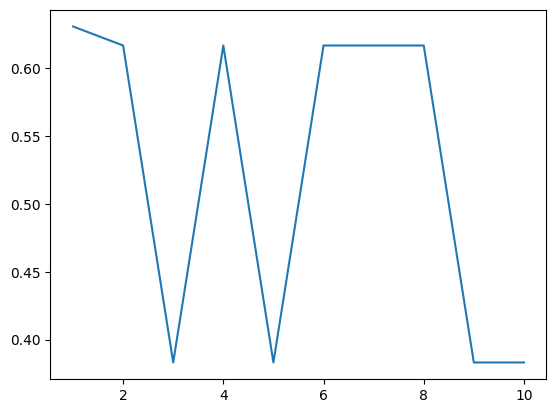

In [28]:
def model_epochs(epoch):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape = (640, 360, 3)),
        tf.keras.layers.Flatten(input_shape=(640, 360, 3)),   
        tf.keras.layers.Dense(32, activation='relu'),    
        tf.keras.layers.Dense(2, activation='softmax')     
    ])

    def my_loss(y_true, y_predict):
        return (y_true-y_predict)**2

    model.compile(optimizer="adam", 
                loss=my_loss,
                metrics=['accuracy'] 
                )

    model.fit(train_ds, epochs=epoch, validation_data=valid_ds)
    loss, accuracy = model.evaluate(test_ds)
    return (loss, accuracy)

epochs = np.arange(1,11,1)
result = [model_epochs(e) for e in epochs]
epoch_losses = [r[0] for r in result]
epoch_accuracies = [r[1] for r in result]

plt.figure()
plt.plot(epochs,epoch_accuracies)
plt.show()

## SVM Model

In [2]:
#Processing the data

categories = {
    0: ["4736","2383","3520"],
    1: ["d20017","26852"]
}

dir = "data/raw_images/"

labels_arr = []
features_arr = []

for cat in categories.keys():
    for folder in categories[cat]:
        cur_path = os.path.join(dir, folder)

        for img in os.listdir(cur_path):
            if img == ".DS_Store":
                continue

            img_array=imread(os.path.join(cur_path,img))
            img_resized=resize(img_array,(640,360,3)) 
            img_resized = rgb2gray(img_resized)
            features_arr.append(img_resized.flatten())
            labels_arr.append(cat) 
        print(f"done {folder}, category {cat}")

labels = np.array(labels_arr)
features = np.array(features_arr)


done 4736, category 0
done 2383, category 0
done 3520, category 0
done d20017, category 1
done 26852, category 1


In [3]:
df=pd.DataFrame(features)  
df['Target']=labels 
df.shape

#input data  
x=df.iloc[:,:-1]  
#output data 
y=df.iloc[:,-1]


In [16]:
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(x,y,test_size=0.20, 
                                               random_state=77, 
                                               stratify=y)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

svm = sklearn.svm.SVC(kernel="linear", probability=True)
svm.fit(x_train, y_train)

# Evaluate the model
y_pred = svm.predict(x_test)
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


[0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1
 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1]


In [17]:
correct = 0
mse = 0
y_test = list(y_test)

for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        correct += 1
    mse += (y_pred[i] - y_test[i])**2

accuracy = correct/len(y_pred)
mse = mse/len(y_pred)

print(f"accuracy: {accuracy}, mse: {mse}")

accuracy: 1.0, mse: 0.0
